In [4]:
# Import findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F

# Pandas and Numpy
import pandas as pd
import numpy as np

# Sklearn for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# StandardScaler for scaling numeric features
from sklearn.preprocessing import StandardScaler

# Matplot and seaborn for graphing
import matplotlib.pyplot as plt
import seaborn as sns


# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()

In [5]:
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]

dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]

combined_df = dfs[0]
for df in dfs [1:]:
    combined_df = combined_df.union(df)

# Show DataFrame
combined_df.show(5)
combined_df.dtypes

+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|       race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+-------------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|Other nonhisp|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|White nonhisp|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|White nonhisp|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|White nonhisp|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|Black no

[('year', 'string'),
 ('state name', 'string'),
 ('region_1', 'string'),
 ('age', 'string'),
 ('sex_1', 'string'),
 ('race_1', 'string'),
 ('martial status', 'string'),
 ('union type', 'string'),
 ('educ99', 'string'),
 ('occ', 'string'),
 ('ind', 'string'),
 ('wkswork1', 'string'),
 ('uhrswork', 'string'),
 ('incwage', 'string')]

In [6]:
# Step 1: Calculate the average salary by year, state name, race, age, union type, and marital status
avg_income_data = (
    combined_df
    .groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income'))  # Calculate average income
)
avg_income_data.show(5)


+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|year|state name|       race_1|age|union type|      martial status|sex_1|       avg_income|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
|1981|   Wyoming|White nonhisp| 57|      NULL|Married, spouse p...| male|          19600.0|
|1981|  Michigan|White nonhisp| 34|      NULL|            Divorced| male|          13250.0|
|1981|      Ohio|White nonhisp| 37|      NULL|Married, spouse p...| male|20747.91304347826|
|1981|    Nevada|White nonhisp| 58|      NULL|Married, spouse p...| male|          20062.5|
|1981|  Delaware|White nonhisp| 38|      NULL|Married, spouse p...| male|          33617.5|
+----+----------+-------------+---+----------+--------------------+-----+-----------------+
only showing top 5 rows



In [7]:
# Pivot to get male and female average incomes
avg_income_pivot = avg_income_data.groupBy(['year', 'state name', 'race_1', 'age', 'union type', 'martial status']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot.show(5)

+----+----------+-------------+---+--------------------+--------------------+----+-------+
|year|state name|       race_1|age|          union type|      martial status|male| female|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
|1990|  New York|Black nonhisp| 42|                 NIU|Married, spouse p...|NULL|33375.0|
|1990|    Alaska|Other nonhisp| 39|                 NIU|            Divorced|NULL|19027.0|
|1990|  Virginia|White nonhisp| 43|Member of labor u...|Married, spouse p...|NULL|17478.0|
|1990|     Texas|Black nonhisp| 34|   No union coverage|           Separated|NULL|15000.0|
|1990|   Wyoming|White nonhisp| 28|                 NIU|            Divorced|NULL|19500.0|
+----+----------+-------------+---+--------------------+--------------------+----+-------+
only showing top 5 rows



In [8]:
# Calculate pay gap (percentage difference)
avg_income_pivot = avg_income_pivot.withColumn('pay_gap', 
    (avg_income_pivot['male'] - avg_income_pivot['female']) / avg_income_pivot['male'] * 100)

# Order and show final results
avg_income_pivot.orderBy('year', 'state name', 'race_1', 'age', 'union type', 'martial status').show(5)

+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|year|state name|       race_1|age|union type|      martial status|              male| female|          pay_gap|
+----+----------+-------------+---+----------+--------------------+------------------+-------+-----------------+
|1981|   Alabama|Black nonhisp| 25|      NULL|Married, spouse p...|           12440.0|8172.25|34.30667202572347|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Never mar|           14000.0| 4000.0|71.42857142857143|
|1981|   Alabama|Black nonhisp| 25|      NULL|           Separated|              NULL| 2075.0|             NULL|
|1981|   Alabama|Black nonhisp| 26|      NULL|Married, spouse p...|10093.666666666666| 2600.0|  74.241273405766|
|1981|   Alabama|Black nonhisp| 27|      NULL|Married, spouse a...|              NULL|12000.0|             NULL|
+----+----------+-------------+---+----------+--------------------+------------------+-------+--

In [9]:
# Convert to Pandas for scikit-learn model
avg_income_pandas = avg_income_pivot.orderBy('year').toPandas()
avg_income_pandas.head()

,year,state name,race_1,age,union type,martial status,male,female,pay_gap
0,1981,California,White nonhisp,48,None,"Married, spouse present",27102.545455,11746.333333,56.659667
1,1981,Alaska,White nonhisp,28,None,"Married, spouse present",30629.500000,16426.666667,46.369785
2,1981,Louisiana,Black nonhisp,54,None,Separated,10500.000000,NaN,NaN
3,1981,Arizona,Hispanic,39,None,Never mar,NaN,14000.000000,NaN
4,1981,Oregon,Hispanic,32,None,"Married, spouse present",4120.000000,4500.000000,-9.223301


In [10]:
import numpy as np
# Data cleaning and preparation
avg_income_pandas.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas['male'].fillna('0', inplace=True)
avg_income_pandas['female'].fillna('0', inplace=True)
avg_income_pandas['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas['male'] = avg_income_pandas['male'].astype(float)
avg_income_pandas['female'] = avg_income_pandas['female'].astype(float)
avg_income_pandas['pay_gap'] = avg_income_pandas['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/2527629748.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_income_pandas['male'].fillna('0', inplace=True)
/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/2527629748.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [11]:
# Handle categorical columns with one-hot encoding
avg_income_pandas = pd.get_dummies(avg_income_pandas, columns=['race_1', 'state name', 'union type', 'martial status'], drop_first=False)


In [12]:
avg_income_pandas.head()

,year,age,male,female,pay_gap,race_1_Black nonhisp,race_1_Hispanic,race_1_Other nonhisp,race_1_White nonhisp,state name_Alabama,...,union type_Covered by union but not a member,union type_Member of labor union,union type_NIU,union type_No union coverage,martial status_Divorced,"martial status_Married, spouse absent","martial status_Married, spouse present",martial status_Never mar,martial status_Separated,martial status_Widowed
0,1981,48,27102.545455,11746.333333,56.659667,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,1981,28,30629.500000,16426.666667,46.369785,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,1981,54,10500.000000,0.000000,0.000000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1981,39,0.000000,14000.000000,0.000000,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1981,32,4120.000000,4500.000000,-9.223301,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [13]:
# Define feature matrix (X) and target vector (y)
X = avg_income_pandas.drop(columns=['pay_gap'])  # Dropping only pay_gap, which is the target
y = avg_income_pandas['pay_gap']  # pay_gap is the target variable, which remains continuous


In [14]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Initialize and fit the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
# Make predictions
y_pred = model.predict(X_test)

In [18]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 8817.277615890061
R-squared: 0.8644341128377802


In [19]:
# Print feature importances
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                                         Feature    Importance
2                                           male  6.535497e-01
3                                         female  2.290306e-01
19                             state name_Hawaii  2.752539e-02
1                                            age  2.467207e-02
0                                           year  1.165408e-02
..                                           ...           ...
32                        state name_Mississippi  9.713829e-07
25                           state name_Kentucky  8.487090e-07
42                       state name_North Dakota  5.195666e-07
52                               state name_Utah  1.193790e-07
60  union type_Covered by union but not a member  9.694991e-10

[70 rows x 2 columns]


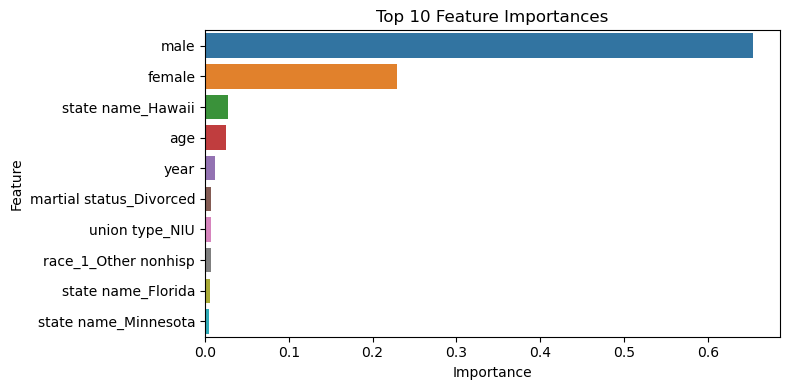

In [36]:
# Assuming X_train_clean.columns contains the feature names
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (most important features at the top)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Show top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [21]:
# Step 1: Calculate the average salary by year, state name, race, age, union type, and marital status
avg_income_data_less_features = (
    combined_df
    .groupBy(['year','age', 'sex_1'])
    .agg(F.mean('incwage').alias('avg_income'))  # Calculate average income
)
avg_income_data_less_features.show(5)


+----+---+------+------------------+
|year|age| sex_1|        avg_income|
+----+---+------+------------------+
|1981| 36|  male|21176.677279305353|
|1981| 60|  male| 18688.27683615819|
|1981| 37|  male|21364.150837988826|
|1981| 35|female|10368.572477064221|
|1981| 62|female|  8408.13294797688|
+----+---+------+------------------+
only showing top 5 rows



In [22]:
# Pivot to get male and female average incomes
avg_income_pivot_less_features = avg_income_data_less_features.groupBy(['year','age']).pivot('sex_1', ['male', 'female']).agg(F.first('avg_income'))
avg_income_pivot_less_features.show(5)

+----+---+------------------+-----------------+
|year|age|              male|           female|
+----+---+------------------+-----------------+
|2009| 50| 72941.98257372653|40710.38036809816|
|2007| 44| 59108.32947368421|37869.35555555556|
|1999| 42|48198.710743801654|         26580.65|
|1990| 53| 32923.18904109589|18208.58258258258|
|2011| 46| 63990.20870678617|41666.79802955665|
+----+---+------------------+-----------------+
only showing top 5 rows



In [23]:
# Calculate pay gap (percentage difference)
avg_income_pivot_less_features = avg_income_pivot_less_features.withColumn('pay_gap', 
    (avg_income_pivot_less_features['male'] - avg_income_pivot_less_features['female']) / avg_income_pivot_less_features['male'] * 100)

# Order and show final results
avg_income_pivot_less_features.orderBy('year', 'age').show(5)

+----+---+------------------+------------------+------------------+
|year|age|              male|            female|           pay_gap|
+----+---+------------------+------------------+------------------+
|1981| 25|13529.103213242453| 9360.390663390663|30.812925913458944|
|1981| 26|14301.984662576688| 9543.998777506113| 33.26801137971128|
|1981| 27|14866.549851924976| 9457.711026615969| 36.38260981318843|
|1981| 28|15898.320696721312|10065.381562099872|36.689026758809554|
|1981| 29| 17011.05642633229|10018.459039548023| 41.10619124136268|
+----+---+------------------+------------------+------------------+
only showing top 5 rows



In [24]:
# Convert to Pandas for scikit-learn model
avg_income_pandas_less_features = avg_income_pivot_less_features.orderBy('year').toPandas()
avg_income_pandas_less_features.head()

,year,age,male,female,pay_gap
0,1981,58,21213.308642,9611.429032,54.691514
1,1981,64,17084.826923,8362.919118,51.050607
2,1981,34,19720.022826,10133.969343,48.610763
3,1981,43,21364.170213,9601.723831,55.056884
4,1981,51,22493.271762,10857.176000,51.731451


In [25]:
# Data cleaning and preparation
avg_income_pandas_less_features.replace({'male': {'None': np.nan}, 'female': {'None': np.nan}, 'pay_gap': {'None': np.nan}}, inplace=True)
avg_income_pandas_less_features.fillna(0, inplace=True)

# Handle NaN variables
avg_income_pandas_less_features['male'].fillna('0', inplace=True)
avg_income_pandas_less_features['female'].fillna('0', inplace=True)
avg_income_pandas_less_features['pay_gap'].fillna('0', inplace=True)

# Convert necessary columns to float
avg_income_pandas_less_features['male'] = avg_income_pandas_less_features['male'].astype(float)
avg_income_pandas_less_features['female'] = avg_income_pandas_less_features['female'].astype(float)
avg_income_pandas_less_features['pay_gap'] = avg_income_pandas_less_features['pay_gap'].astype(float)



/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/1818963439.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_income_pandas_less_features['male'].fillna('0', inplace=True)
/var/folders/jz/_p_lld1s29s8d9d81cx0tzmw0000gn/T/ipykernel_22464/1818963439.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [26]:
# Define feature matrix (X) and target vector (y)
X_2 = avg_income_pandas_less_features.drop(columns=['pay_gap'])  # Dropping only pay_gap, which is the target
y_2 = avg_income_pandas_less_features['pay_gap']  # pay_gap is the target variable, which remains continuous


In [27]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)


In [28]:
# Standard scaling
scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

In [29]:
# Initialize and fit the RandomForestRegressor model
model_2 = RandomForestRegressor()
model_2.fit(X_train_2, y_train_2)

RandomForestRegressor()

In [30]:
# Make predictions
y_pred_2 = model_2.predict(X_test_2)

In [31]:
# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test_2, y_pred_2))
print("R-squared:", r2_score(y_test_2, y_pred_2))

Mean Squared Error: 8.08841865676879
R-squared: 0.9235446422358619


In [32]:
# Print feature importances
updated_importances = model_2.feature_importances_
updated_feature_names = X_2.columns
updated_importance_df = pd.DataFrame({'Feature': updated_feature_names, 'Importance': updated_importances})
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)
print("\nUpdated Feature Importances:")
print(updated_importance_df)


Updated Feature Importances:
  Feature  Importance
1     age    0.459381
3  female    0.389641
2    male    0.083774
0    year    0.067203


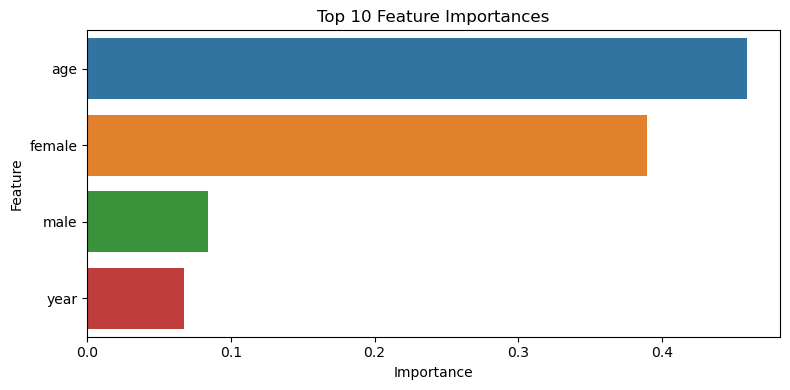

In [35]:
# Assuming X_train_clean.columns contains the feature names
updated_feature_importances = model_2.feature_importances_

# Create a DataFrame with feature names and their importance scores
updated_importance_df = pd.DataFrame({
    'Feature': updated_feature_names,
    'Importance': updated_feature_importances
})

# Sort the DataFrame by importance (most important features at the top)
updated_importance_df = updated_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=updated_importance_df.head(10))  # Show top 10 features
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
